In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train (1).csv")
data = df.sample(n = 50000, random_state = 42)

In [4]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
119105,7ca72b5b9c688e9e,"Geez, are you forgetful! We've already discus...",0,0,0,0,0,0
131631,c03f72fd8f8bf54f,Carioca RFA \n\nThanks for your support on my ...,0,0,0,0,0,0
125326,9e5b8e8fc1ff2e84,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,0,0,0,0,0
111256,5332799e706665a6,Pseudoscience category? \n\nI'm assuming that ...,0,0,0,0,0,0
83590,dfa7d8f0b4366680,"(and if such phrase exists, it would be provid...",0,0,0,0,0,0


In [5]:
data.shape

(50000, 8)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 119105 to 52099
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             50000 non-null  object
 1   comment_text   50000 non-null  object
 2   toxic          50000 non-null  int64 
 3   severe_toxic   50000 non-null  int64 
 4   obscene        50000 non-null  int64 
 5   threat         50000 non-null  int64 
 6   insult         50000 non-null  int64 
 7   identity_hate  50000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 3.4+ MB


In [7]:
data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
from tensorflow.keras.layers import TextVectorization as tv

In [9]:
X = data['comment_text']
Y = data[data.columns[2:]].values

In [10]:
vectorizer = tv(max_tokens = 10000,
               output_sequence_length = 1000,
               output_mode = 'int')

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, Y))
dataset = dataset.cache()
dataset = dataset.shuffle(60000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM ,Dropout,Bidirectional,Dense,Embedding

In [16]:
model = Sequential()
model.add(Embedding(10000+1,32))
model.add(Bidirectional(LSTM(32,activation = 'tanh')))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(6,activation = 'sigmoid'))

model.build(input_shape=(None, 1000))

In [17]:
model.compile(loss = 'BinaryCrossentropy' , optimizer = 'Adam',metrics=['accuracy'] )
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1000, 32)            │         320,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 411,686 (1.57 MB)

 Trainable params: 411,686 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_train = model.fit(train ,
                          epochs = 4,
                          validation_data = val)

Epoch 1/4
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 128s 56ms/step - accuracy: 0.8727 - loss: 0.1212 - val_accuracy: 0.9948 - val_loss: 0.0570
Epoch 2/4
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 137s 55ms/step - accuracy: 0.9850 - loss: 0.0540 - val_accuracy: 0.9940 - val_loss: 0.0519
Epoch 3/4
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 122s 56ms/step - accuracy: 0.9908 - loss: 0.0502 - val_accuracy: 0.9945 - val_loss: 0.0478
Epoch 4/4
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 124s 57ms/step - accuracy: 0.9936 - loss: 0.0467 - val_accuracy: 0.9951 - val_loss: 0.0407


<Figure size 800x500 with 0 Axes>

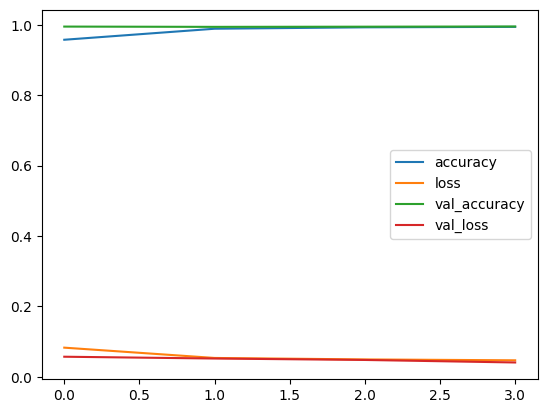

In [19]:
from matplotlib import pyplot as plt

plt.figure(figsize = (8,5))
pd.DataFrame(model_train.history).plot()
plt.show()

In [25]:
model.save('/content/drive/MyDrive/Colab Notebooks/comment_toxicity.h5')

In [21]:
import tensorflow as tf
import gradio as gr

In [26]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/comment_toxicity.h5')

In [32]:
def predict_toxicity(comments) :
  vectorized_text = vectorizer([comments])
  results = model.predict(vectorized_text)

  text = ""
  for idx ,col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    text += '{}: {}\n'.format(col, int(results[0][idx] > 0.5))

  return text

In [33]:
gui = gr.Interface(
    fn=predict_toxicity,
    inputs=gr.Textbox(lines=2, placeholder='Comment to Score'),
    outputs='text'
)
gui.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4f7b7ffad72648d92a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
